In [3]:
import sys
import os

__dir__ = os.path.dirname(os.path.abspath("__file__"))
sys.path.append(__dir__)
sys.path.insert(0, os.path.abspath(os.path.join(__dir__, "..")))


In [4]:
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [5]:
import numpy as np
from skimage.transform import resize


In [6]:
# import craft functions
from my_craft_text_detector.craft_text_detector import (
    read_image,
    load_craftnet_model,
    load_refinenet_model,
    get_prediction,
    export_detected_regions,
    export_extra_results,
    empty_cuda_cache
)
refine_net = load_refinenet_model(cuda=True)
craft_net = load_craftnet_model(cuda=True)

/opt/miniconda3/envs/ocr/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


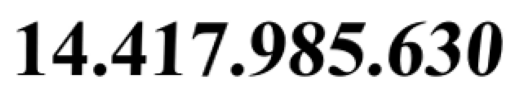

In [7]:
import os
# os.listdir("/data/ocr/data/text_recognition/ocr_data_v3_280225/Arial_Bold/images/img_18563.jpg")
import matplotlib.pyplot as plt
import cv2
image_path = "/home/app/ocr/vts-document-ai/text_extractor/output/img_14.417.985.630_1.png"
# image_path = "/home/app/ocr/vts-document-ai/text_extractor/output/img_1_GIÁM.png"
image = cv2.imread(image_path)
h,w,_ = image.shape
plt.axis('off')
plt.imshow(image)

In [8]:
image.shape

(43, 304, 3)

In [9]:
# import cv2
# import matplotlib.pyplot as plt

# # Load the color image
# image_path = "/home/app/ocr/vts-document-ai/text_extractor/output/img_1_Nơị.png"
# image = cv2.imread(image_path)

# # Define a kernel for the erosion operation (3x3 kernel)
# # kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
# kernel = np.array([[0, 0, 0],
#                    [0, 1, 0],
#                    [0, 0, 0]], dtype=np.uint8)

# # Apply erosion to the color image (this will apply erosion to each color channel separately)
# eroded_image = cv2.dilate(image, kernel, iterations=1)

# # Display the original and eroded images
# plt.subplot(1, 2, 1)
# plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
# plt.title('Original Image')
# plt.axis('off')

# plt.subplot(1, 2, 2)
# plt.imshow(cv2.cvtColor(eroded_image, cv2.COLOR_BGR2RGB))
# plt.title('Eroded Image')
# plt.axis('off')

# plt.show()



In [10]:
desired_long_size = max(h,w)
ratio = desired_long_size/max(h,w)
unpadded_target_h = int(h * ratio)
unpadded_target_w = int(w*ratio)
padded_h = 32 if not unpadded_target_h%32 else unpadded_target_h%32
padded_w = 32 if not unpadded_target_w%32 else unpadded_target_w%32
padded_target_h = unpadded_target_h + 32 - padded_h
padded_target_w = unpadded_target_w + 32 - padded_w

print(padded_target_h)
print(padded_target_w)

64
320


In [11]:
# set image path and export folder directory
output_dir = 'outputs/'

# read image
# image = read_image(image)
# perform prediction
prediction_result = get_prediction(
    image=image,
    craft_net=craft_net,
    # refine_net=refine_net,
    text_threshold=0.6,
    link_threshold=1,
    low_text=0.6,
    cuda=True,
    long_size=desired_long_size
)

# export detected text regions
exported_file_paths = export_detected_regions(
    image=image,
    regions=prediction_result["boxes"],
    output_dir=output_dir,
    rectify=True
)

# export heatmap, detection points, box visualization
export_extra_results(
    image=image,
    regions=prediction_result["boxes"],
    heatmaps=prediction_result["heatmaps"],
    output_dir=output_dir
)

# unload models from gpu
empty_cuda_cache()

(32, 160)

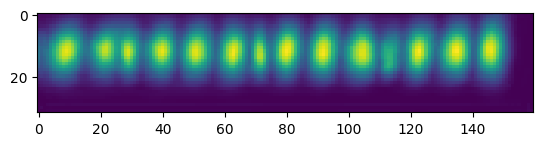

In [12]:
plt.imshow(prediction_result['score_text'])
prediction_result['score_text'].shape


# Process segmap

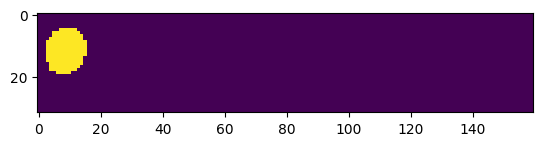

In [13]:
segmap_list = prediction_result['segmap_list']
plt.imshow(segmap_list[1])

1.0


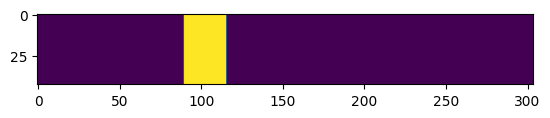

In [14]:
segmap = segmap_list[2]
image = cv2.imread(image_path)
expended_ratio = 0.1
segmap = resize(segmap, (padded_target_h,padded_target_w), anti_aliasing=True)
segmap = segmap[:unpadded_target_h,:unpadded_target_w]
segmap[segmap>0] = 1
coords = np.column_stack(np.where(segmap > 0))
leftmost = coords[np.argmin(coords[:, 1])][1]
rightmost = coords[np.argmax(coords[:, 1])][1]

segmap_width = rightmost - leftmost
expended_width = expended_ratio*segmap_width//2
print(expended_width)
leftmost = int(max(0, leftmost-expended_width))
rightmost = int(min(w, rightmost+expended_width))
segmap[:,leftmost:rightmost+1] = 1

plt.imshow(segmap)

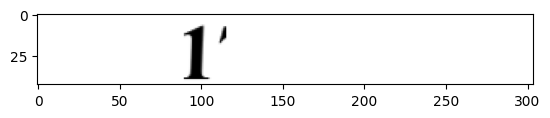

In [15]:
mask = np.stack([segmap,segmap,segmap], axis = -1)
mask = np.clip(mask, 0, 255).astype(np.uint8)
plt.imshow(mask*image + (1-mask)*255)


# Wrap function

In [16]:
###### Wrap to function
def get_char(image_path):
    image = cv2.imread(image_path)
    h,w,_ = image.shape
    char_images = []
    prediction_result = get_prediction(
        image=image,
        craft_net=craft_net,
        # refine_net=refine_net,
        text_threshold=0.6,
        link_threshold=1,
        low_text=0.6,
        cuda=True,
        long_size=1000
    )
    segmap_list = prediction_result['segmap_list']
    for i in range(len(segmap_list)):
        segmap = segmap_list[i]
        
        expended_ratio = 0.1
        segmap = resize(segmap, (h,w), anti_aliasing=True)
        segmap[segmap>0] = 1
        coords = np.column_stack(np.where(segmap > 0))
        leftmost = coords[np.argmin(coords[:, 1])][1]
        rightmost = coords[np.argmax(coords[:, 1])][1]

        segmap_width = rightmost - leftmost
        expended_width = expended_ratio*segmap_width//2
        print(expended_width)
        leftmost = int(max(0, leftmost-expended_width))
        rightmost = int(min(w, rightmost+expended_width))
        segmap[:,leftmost:rightmost+1] = 1

        # plt.imshow(segmap)
        mask = np.stack([segmap,segmap,segmap], axis = -1)
        mask = np.clip(mask, 0, 255).astype(np.uint8)
        # char_img = imshow(mask*image + (1-mask)*255)
        char_images.append(mask*image + (1-mask)*255)
        # plt.imshow(mask*image + (1-mask)*255)
    return char_images

In [17]:
# chars = get_char("/home/app/ocr/vts-document-ai/text_extractor/output/img_1_Nơị.png")

In [18]:
# plt.imshow(chars[2])

# Process link

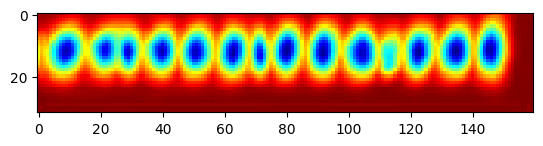

In [19]:
array_img = np.load("/home/app/ocr/kientdt/CharOCR/CRAFT/outputs/array_img/label_1.npy")
# text_score = np.load("/home/app/ocr/kientdt/CharOCR/CRAFT/outputs/array_img/textscore.npy")
link_score = cv2.imread("/home/app/ocr/kientdt/CharOCR/CRAFT/outputs/image_link_score_heatmap.png")
text_score = cv2.imread("/home/app/ocr/kientdt/CharOCR/CRAFT/outputs/image_text_score_heatmap.png")
plt.imshow(text_score)

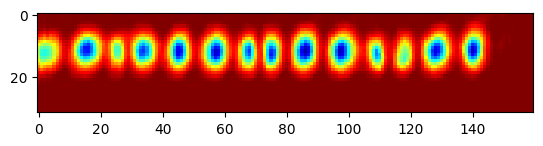

In [20]:
plt.imshow(link_score)

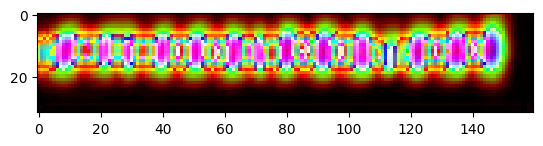

In [21]:
plt.imshow(link_score + text_score)

In [22]:
(padded_target_w - unpadded_target_w) // 2

8

In [25]:
# plt.imshow(resized_textscore)

In [26]:
text_score = prediction_result['score_text']
link_score = prediction_result['score_link']
# resized_arr = resize(array_img, (h,w), anti_aliasing=True)
resized_textscore = resize(text_score, (padded_target_h, padded_target_w), anti_aliasing=True)
resized_linkscore = resize(link_score, (padded_target_h, padded_target_w), anti_aliasing=True)

resized_textscore = resized_textscore[:unpadded_target_h, :unpadded_target_w]
resized_linkscore = resized_linkscore[:unpadded_target_h, :unpadded_target_w]

resized_textscore = resize(resized_textscore, (h,w), cv2.INTER_LINEAR)
resized_linkscore = resize(resized_linkscore, (h,w), cv2.INTER_LINEAR)


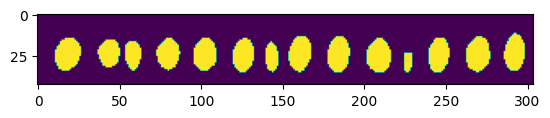

In [27]:
ret,link_mask = cv2.threshold(resized_linkscore, 0.5,1,0)
ret, score_mask = cv2.threshold(resized_textscore, 0.6,1,0)
plt.imshow(score_mask)
# link_mask.shape


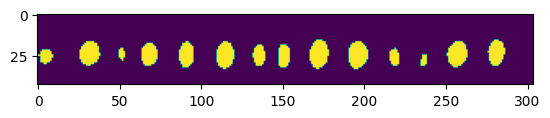

In [28]:
plt.imshow(link_mask)

In [52]:
nLabels, labels, stats, centroids = cv2.connectedComponentsWithStats(
        link_mask.astype(np.uint8), connectivity=4
    )

In [53]:
coor_to_split = []
for i in range(1,nLabels):
    points = np.where(labels == i)
    # x_average = int(np.average(points[1]))
    x_average = int(np.max(points[1]))
    coor_to_split.append(x_average)
coor_to_split


[178, 286, 38, 95, 120, 202, 263, 73, 139, 154, 53, 221, 9, 238]

In [54]:
image = cv2.imread(image_path)


In [55]:
for i in range(len(coor_to_split)):
    image[:,coor_to_split[i]:coor_to_split[i]+1,1] = 0
image_name = image_path.split("/")[-1]
cv2.imwrite(f"links_outputs/{image_name}",image)

True

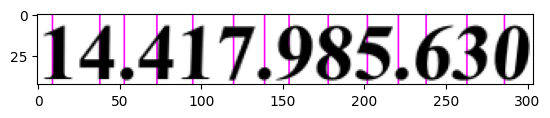

In [56]:
plt.imshow(image)


In [191]:
score_mask = score_mask.astype(np.uint8)
contours, _ = cv2.findContours(score_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

In [151]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def find_italic_character_angles(mask_image):
    """
    Find the orientation angles of italic characters in a binary mask image.
    
    Parameters:
    mask_image (numpy.ndarray): Binary mask image with characters
    
    Returns:
    list: List of character information including angles
    numpy.ndarray: Visualization image
    """
    # Make a copy of the input image
    img = mask_image.copy().astype(np.uint8)
    
    # Convert to grayscale if needed
    if len(img.shape) == 3:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        gray = img.copy()
    
    # Ensure we have a binary image
    # _, binary = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)
    
    # Find contours
    contours, _ = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Create output image for visualization
    vis_img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    
    # Process each contour and collect character information
    characters = []
    for i, contour in enumerate(contours):
        # Need at least 5 points to fit an ellipse
        if len(contour) >= 5:
            # Fit ellipse
            ellipse = cv2.fitEllipse(contour)
            
            # Extract ellipse parameters
            (center_x, center_y), (width, height), angle = ellipse[0], ellipse[1], ellipse[2]
            
            # Determine the angle of the major axis (italic angle)
            if width < height:
                # If height > width, the major axis is height
                major_axis = height
                minor_axis = width
                italic_angle = angle + 90
                if italic_angle >= 180:
                    italic_angle -= 180
            else:
                # If width >= height, the major axis is width
                major_axis = width
                minor_axis = height
                italic_angle = angle
            
            # Store character information
            character_info = {
                'id': i+1,
                'center': (center_x, center_y),
                'angle': italic_angle,
                'major_axis': major_axis,
                'minor_axis': minor_axis,
                'area': cv2.contourArea(contour)
            }
            characters.append(character_info)
            
            # Draw ellipse on the visualization image
            cv2.ellipse(vis_img, ellipse, (0, 255, 0), 2)
            
            # Draw major axis line to show the italic angle
            rads = np.deg2rad(italic_angle)
            x_end = center_x + (major_axis/2) * np.cos(rads)
            y_end = center_y + (major_axis/2) * np.sin(rads)
            
            rads = np.deg2rad(italic_angle)
            
            # Get image dimensions
            h, w = vis_img.shape[:2]
            line_length = max(w, h) * 2  # Make line long enough to cross entire image
            
            # Calculate line endpoints
            x1 = center_x - line_length * np.cos(rads)
            y1 = center_y - line_length * np.sin(rads)
            x2 = center_x + line_length * np.cos(rads)
            y2 = center_y + line_length * np.sin(rads)
            
            # Draw the line through center
            cv2.line(vis_img, 
                    (int(x1), int(y1)), 
                    (int(x2), int(y2)), 
                    (0, 0, 255),  # Red color
                    1)  # Thinner line to see through ellipse
            
            # Draw a shorter, thicker line segment for emphasis
            x_end1 = center_x - (major_axis/2) * np.cos(rads)
            y_end1 = center_y - (major_axis/2) * np.sin(rads)
            x_end2 = center_x + (major_axis/2) * np.cos(rads)
            y_end2 = center_y + (major_axis/2) * np.sin(rads)
            
            cv2.line(vis_img, 
                    (int(x_end1), int(y_end1)), 
                    (int(x_end2), int(y_end2)), 
                    (0, 0, 255),  # Red color
                    2)  # Thicker line
            
            
            cv2.line(vis_img, 
                    (int(center_x), int(center_y)), 
                    (int(x_end), int(y_end)), 
                    (0, 0, 255), 
                    2)
            
            # Add angle text
            # cv2.putText(vis_img, 
            #            f"{italic_angle:.1f}°", 
            #            (int(center_x) - 20, int(center_y) - 20), 
            #            cv2.FONT_HERSHEY_SIMPLEX, 
            #            0.5, 
            #            (255, 0, 0), 
            #            1)
    
    # Sort characters from left to right
    characters.sort(key=lambda c: c['center'][0])
    
    return characters, vis_img
char, vis = find_italic_character_angles(score_mask)


In [152]:
char

[{'id': 4,
  'center': (26.761241912841797, 28.47611427307129),
  'angle': 42.446136474609375,
  'major_axis': 31.669010162353516,
  'minor_axis': 30.33571434020996,
  'area': 748.5},
 {'id': 5,
  'center': (64.43401336669922, 28.923110961914062),
  'angle': 87.60008239746094,
  'major_axis': 32.67947006225586,
  'minor_axis': 18.50489044189453,
  'area': 473.0},
 {'id': 3,
  'center': (93.60346984863281, 29.80364418029785),
  'angle': 84.79733276367188,
  'major_axis': 31.985733032226562,
  'minor_axis': 21.599750518798828,
  'area': 534.0},
 {'id': 2,
  'center': (124.3130111694336, 31.867595672607422),
  'angle': 90.02995270118117,
  'major_axis': 32.412841796875,
  'minor_axis': 18.316844940185547,
  'area': 462.0},
 {'id': 1,
  'center': (152.28282165527344, 34.44420623779297),
  'angle': 87.96098327636719,
  'major_axis': 32.544803619384766,
  'minor_axis': 19.514692306518555,
  'area': 491.0}]

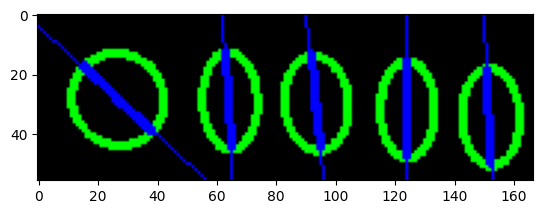

In [153]:
plt.imshow(vis)

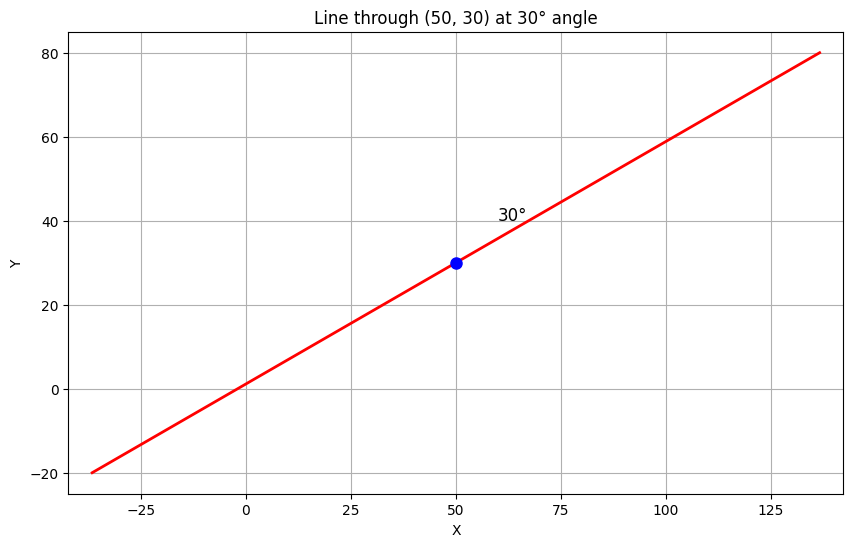

In [154]:
import numpy as np
import matplotlib.pyplot as plt

def draw_line_through_point(point, angle_degrees, line_length=100, figsize=(10, 6)):
    """
    Draw a line through a point at a specified angle using Matplotlib.
    
    Parameters:
    point (tuple): (x, y) coordinates of the point
    angle_degrees (float): Angle in degrees (0 = right, 90 = up)
    line_length (float): Length of the line in both directions
    figsize (tuple): Figure size
    """
    # Convert angle to radians
    angle_rad = np.deg2rad(angle_degrees)
    
    # Calculate line endpoints
    x, y = point
    dx = np.cos(angle_rad) * line_length
    dy = np.sin(angle_rad) * line_length
    
    # Line goes through point in both directions
    x1 = x - dx
    y1 = y - dy
    x2 = x + dx
    y2 = y + dy
    
    # Create plot
    plt.figure(figsize=figsize)
    
    # Plot the line
    plt.plot([x1, x2], [y1, y2], 'r-', linewidth=2)
    
    # Plot the center point
    plt.plot(x, y, 'bo', markersize=8)
    
    # Add angle annotation
    plt.annotate(f"{angle_degrees}°", 
                 xy=(x, y), 
                 xytext=(x + 10, y + 10),
                 fontsize=12)
    
    plt.grid(True)
    plt.axis('equal')
    plt.title(f"Line through ({x}, {y}) at {angle_degrees}° angle")
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.show()

# Example usage
point = (50, 30)  # Center point
angle = 30  # Angle in degrees
draw_line_through_point(point, angle)


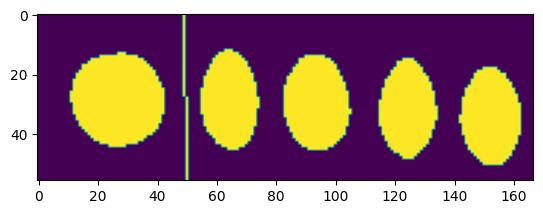

In [155]:
import cv2
import numpy as np

def draw_line_through_point_on_image(image, point, angle_degrees, color=(1, 1, 1), 
                                     thickness=1, line_extension=1000):
    """
    Draw a line through a point at a specified angle on an image using OpenCV.
    
    Parameters:
    image (numpy.ndarray): Input image
    point (tuple): (x, y) coordinates of the point
    angle_degrees (float): Angle in degrees (0 = horizontal, angle increases counter-clockwise)
    color (tuple): BGR color of the line
    thickness (int): Line thickness
    line_extension (int): How far to extend the line in both directions
    
    Returns:
    numpy.ndarray: Image with the line drawn
    """
    # Make a copy of the image
    img_copy = image.copy()
    
    # Get image dimensions
    h, w = img_copy.shape[:2]
    
    # Convert angle to radians (OpenCV uses counter-clockwise angles from horizontal)
    angle_rad = np.deg2rad(angle_degrees)
    
    # Calculate the line vector
    dx = np.cos(angle_rad) * line_extension
    dy = np.sin(angle_rad) * line_extension
    
    # Calculate endpoint coordinates
    x, y = point
    pt1 = (int(x - dx), int(y - dy))
    pt2 = (int(x + dx), int(y + dy))
    
    # Draw the line through the point
    cv2.line(img_copy, pt1, pt2, color, thickness)
    
    # Draw the center point
    # cv2.circle(img_copy, (int(x), int(y)), 5, (0, 255, 0), -1)
    
    # Add angle text
    
    return img_copy
point = (50, 31)  # Center point
angle = 90  # Angle in degrees
result = draw_line_through_point_on_image(score_mask, point, angle)
plt.imshow(result)